In [54]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.12.0


In [55]:
!dir

drive  sample_data


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of images found:  1070
Shape of image:  (40, 150, 3)
Shape of image:  (40, 150, 3)
Shape of image:  (40, 150, 3)
Shape of image:  (40, 150, 3)


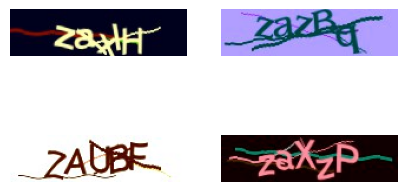

In [84]:
# Path to the data directory

# train 모델의 캡챠 글자 개수 결정.
captcha=5

# images : 글자 4개
# samples : 글자 5개
data_dir = Path("/content/drive/MyDrive/input/archive")

# Get list of all the images
images = list(data_dir.glob("*.png"))
images += list(data_dir.glob("*.jpg"))
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [85]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:

  if str(img_path)[-3:] == 'jpg':
    label = img_path.name.split(".jpg")[0]
  else:
    label = img_path.name.split(".png")[0]
  # 2. Store the length of this cpatcha
  captcha_length.append(len(label))
  # 3. Store the image-label pair info
  dataset.append((str(img_path), label))
    
  # 4. Store the characters present
  for ch in label:
    characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  60
Maximum length of any captcha:  5
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of samples in the dataset:  1070


,img_path,label
0,/content/drive/MyDrive/input/archive/zsCiK.jpg,zsCiK
1,/content/drive/MyDrive/input/archive/zWM8S.jpg,zWM8S
2,/content/drive/MyDrive/input/archive/zZb3T.jpg,zZb3T
3,/content/drive/MyDrive/input/archive/zTP3a.jpg,zTP3a
4,/content/drive/MyDrive/input/archive/zaUbf.jpg,zaUbf


In [86]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))



# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Store arrays in memory as it's not a much big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  963
Number of validation samples:  107
Number of training images:  (963, 50, 200)
Number of training labels:  (963,)
Number of validation images:  (107, 50, 200)
Number of validation labels:  (107,)


In [87]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5, # 글자 개수에 맞춰서 4개 or 5개
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [88]:
# Batch size for training and validation
batch_size = 32

# Desired image dimensions
img_width=200
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
# 글자 개수에 맞춰서 4개 or 5개
max_length = captcha

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [89]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model(opt, lr=0.001):
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.legacy.SGD(learning_rate=lr,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    Adam = tf.keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True)

    if opt=='SGD':
      opt=sgd

    if opt=='Adam':
      opt=Adam  
      
    # Compile the model and return
    model.compile(optimizer=opt, metrics=['accuracy'])
    return model

In [94]:
model = build_model(opt='Adam', lr=0.001)
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        restore_best_weights=True)

# Train the model
history = model.fit_generator(train_data_generator,
                          validation_data=valid_data_generator,
                          epochs=100,
                          callbacks=[es])

Epoch 1/100


<ipython-input-94-e6ac3432fb76>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_generator,


31/31 [==============================] - 11s 93ms/step - loss: 36.3917 - accuracy: 0.0000e+00 - val_loss: 20.3412 - val_accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 2s 75ms/step - loss: 19.9586 - accuracy: 0.0000e+00 - val_loss: 19.5849 - val_accuracy: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 2s 58ms/step - loss: 19.0636 - accuracy: 0.0000e+00 - val_loss: 18.5204 - val_accuracy: 0.0000e+00
Epoch 4/100
31/31 [==============================] - 1s 43ms/step - loss: 18.3458 - accuracy: 0.0000e+00 - val_loss: 18.0469 - val_accuracy: 0.0000e+00
Epoch 5/100
31/31 [==============================] - 1s 42ms/step - loss: 18.0499 - accuracy: 0.0000e+00 - val_loss: 17.9226 - val_accuracy: 0.0000e+00
Epoch 6/100
31/31 [==============================] - 1s 43ms/step - loss: 17.9575 - accuracy: 0.0000e+00 - val_loss: 17.8717 - val_accuracy: 0.0000e+00
Epoch 7/100
31/31 [==============================] - 1s 42ms/step - loss: 17.9358 - accuracy: 0.000

In [83]:
model.save(f'/content/drive/MyDrive/ML/model_for_samples.h5')

In [63]:
# optimzier와 learing rate별로 그래프 그리기
'''
optimzier 종류:
SGD
RMSprop
Adam
AdamW => X
Adadelta
Adagrad
Adamax
Adafactor => X
Nadam
Ftrl
'''

# 디렉토리 주소: 5_captcha or 4_captcha.

def lr_and_opt_test(lr_list, opt_list):
  for lr in lr_list:
    for opt in opt_list:
      print('****************** optimizer:',opt,'lr:',lr,'******************')
      model = build_model(opt=opt)
      # Add early stopping
      es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        restore_best_weights=True)

      # Train the model
      history = model.fit_generator(train_data_generator,
                          validation_data=valid_data_generator,
                          epochs=100,
                          callbacks=[es])
      
      final_acc = history.history['accuracy'][-1]
      final_val_acc = history.history['val_accuracy'][-1]

      # 정확도 그래프 그리기 및 저장
      plt.plot(history.history['accuracy'], color='red')
      plt.plot(history.history['val_accuracy'], color='blue')
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train_accuracy', 'test_accuracy'], loc='upper left')
      plt.savefig(f'/content/drive/MyDrive/ML/{captcha}_captcha/{opt}/model_acc_{lr}.png') # 디렉토리 주소: 5_captcha or 4_captcha.

      plt.clf() # 그래프 초기화

      # loss 그래프 그리기 및 저장
      plt.plot(history.history['loss'], color='brown')
      plt.plot(history.history['val_loss'], color='green')
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train_loss', 'test_loss'], loc='upper left')
      plt.savefig(f'/content/drive/MyDrive/ML/{captcha}_captcha/{opt}/model_loss_{lr}.png') # 디렉토리 주소: 5_captcha or 4_captcha.

      plt.clf() # 그래프 초기화

      # acc과 loss 둘 다 반영한 그래프
      plt.plot(history.history['accuracy'], color='red')
      plt.plot(history.history['loss'], color='brown')
      plt.plot(history.history['val_accuracy'], color='blue')
      plt.plot(history.history['val_loss'], color='green')
      plt.xlabel('epoch')
      plt.legend(['train_accuracy', 'train_loss', 'test_accuracy', 'test_loss'], loc='upper left')
      plt.savefig(f'/content/drive/MyDrive/ML/{captcha}_captcha/{opt}/model_acc_loss_{lr}.png') # 디렉토리 주소: 5_captcha or 4_captcha.

      plt.clf() # 그래프 초기화

      # log.txt에 값 저장하기. columns: opt,	lr,	train_acc,	test_acc
      file_path = f'/content/drive/MyDrive/ML/{captcha}_captcha/log.txt' # 디렉토리 주소: 5_captcha or 4_captcha.
      new_text_content = ''

      with open(file_path,'r') as f:
        lines = f.readlines()
        for i, l in enumerate(lines):
          new_string = l.strip()
          if new_string:
            new_text_content += new_string + '\n'
            
      new_text_content += f'{opt}\t{lr}\t{final_acc}\t{final_val_acc}' + '\n'
        
      with open(file_path, 'w') as f:
          f.write(new_text_content)

      model.save(f'/content/drive/MyDrive/ML/{captcha}_captcha/Model/model_{opt}_{lr}.h5')

lr_list = [0.002, 0.003]
opt_list = ['SGD','Adam']
lr_and_opt_test(lr_list, opt_list)

****************** optimizer: SGD lr: 0.002 ******************
Epoch 1/100


<ipython-input-63-96bb6cf6ce3b>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_generator,


30/30 [==============================] - 18s 159ms/step - loss: 28.6261 - accuracy: 0.0000e+00 - val_loss: 16.5584 - val_accuracy: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 1s 43ms/step - loss: 16.3519 - accuracy: 0.0000e+00 - val_loss: 16.4885 - val_accuracy: 0.0000e+00
Epoch 3/100
30/30 [==============================] - 1s 42ms/step - loss: 16.3359 - accuracy: 0.0000e+00 - val_loss: 16.4759 - val_accuracy: 0.0000e+00
Epoch 4/100
30/30 [==============================] - 1s 42ms/step - loss: 16.3103 - accuracy: 0.0000e+00 - val_loss: 16.4025 - val_accuracy: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 1s 40ms/step - loss: 16.2920 - accuracy: 0.0000e+00 - val_loss: 16.3912 - val_accuracy: 0.0000e+00
Epoch 6/100
30/30 [==============================] - 1s 41ms/step - loss: 16.2504 - accuracy: 0.0000e+00 - val_loss: 16.4101 - val_accuracy: 0.0000e+00
Epoch 7/100
30/30 [==============================] - 1s 43ms/step - loss: 16.1696 - accuracy: 0.00

<Figure size 640x480 with 0 Axes>

In [96]:
# model 테스트 해 보기.

test_data_dir = Path("/content/drive/MyDrive/input/samples")

# Get list of all the images
images = list(test_data_dir.glob("*.jpg"))
print("Number of images found: ", len(images))

  # Store all the characters in a set
characters = set()

  # A list to store the length of each captcha
captcha_length = []

  # Store image-label info
dataset = []

  # Iterate over the dataset and store the
  # information needed
for img_path in images:
  # 1. Get the label associated with each image
  if str(img_path)[-3:] == 'png':
    label = img_path.name.split(".png")[0]
  else:
    label = img_path.name.split(".jpg")[0]
  # 2. Store the length of this cpatcha
  captcha_length.append(len(label))
  # 3. Store the image-label pair info
  dataset.append((str(img_path), label))    
  # 4. Store the characters present
  for ch in label:
    characters.add(ch)

  # Sort the characters        
characters = sorted(characters)

  # Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

  # Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)

  # Build test data
test_data, test_labels = generate_arrays(df=dataset)
print("Number of test images: ", test_data.shape)
print("Number of test labels: ", test_labels.shape)

  # Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

  # Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}

  # Batch size for training and validation
batch_size = 32

  # Desired image dimensions
img_width=200
img_height=50 

  # Factor  by which the image is going to be downsampled
  # by the convolutional blocks
downsample_factor=4

  # Maximum length of any captcha in the data
  # 글자 개수에 맞춰서 4개 or 5개
max_length=5

  # Get a generator object for the validation data 
test_data_generator = DataGenerator(data=test_data,
                                      labels=test_labels,
                                      char_map=char_to_labels,
                                      batch_size=batch_size,
                                      img_width=img_width,
                                      img_height=img_height,
                                      downsample_factor=downsample_factor,
                                      max_length=max_length,
                                      shuffle=False
                                      )

model_addr = '/content/drive/MyDrive/captcha_recognition_model.h5' # 모델 주소 입력
test_model = tf.keras.models.load_model(model_addr, custom_objects={"CTCLayer": CTCLayer})
print(test_model.evaluate(test_data_generator))

Number of images found:  30
Number of test images:  (30, 50, 200)
Number of test labels:  (30,)
1/1 [==============================] - 2s 2s/step - loss: 0.0428 - accuracy: 1.0000
[0.04283486679196358, 1.0]


In [98]:
prediction_model = keras.models.Model(test_model.get_layer(name='input_data').input,
                                        test_model.get_layer(name='dense2').output)

# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

p_texts = []
o_texts = []

#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

    p_texts.append(pred_texts)
    o_texts.append(orig_texts)
    
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]} \t Correct: {orig_texts[i]==pred_texts[i]}')
    break

1/1 [==============================] - 33s 33s/step
Ground truth: 85pew 	 Predicted: 85pew 	 Correct: True
Ground truth: ygce8 	 Predicted: ygce8 	 Correct: True
Ground truth: gmmne 	 Predicted: gmmne 	 Correct: True
Ground truth: n3xfg 	 Predicted: n3xfg 	 Correct: True
Ground truth: fgb36 	 Predicted: fgb36 	 Correct: True
Ground truth: bgxcd 	 Predicted: bgxcd 	 Correct: True
Ground truth: w6ny4 	 Predicted: w6ny4 	 Correct: True
Ground truth: yge7c 	 Predicted: yge7c 	 Correct: True
Ground truth: ewyg7 	 Predicted: ewyg7 	 Correct: True
Ground truth: f6bpw 	 Predicted: f6bpw 	 Correct: True
Ground truth: pcmcc 	 Predicted: pcmcc 	 Correct: True
Ground truth: 62fgn 	 Predicted: 62fgn 	 Correct: True
Ground truth: nxf2c 	 Predicted: nxf2c 	 Correct: True
Ground truth: e3cfe 	 Predicted: e3cfe 	 Correct: True
Ground truth: 2nbc5 	 Predicted: 2nbc5 	 Correct: True
Ground truth: b4ndb 	 Predicted: b4ndb 	 Correct: True
Ground truth: yw8y5 	 Predicted: yw8y5 	 Correct: True
Ground truth:

In [ ]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

**Please upvote if you liked the notebook.**